## Preprocessing for Fiber Photometry data

0. Import libraries [Go](#0-import-libraries)
1. User inputs [Go](#1-user-inputs)
2. Import data [Go](#2-import-data)
3. Browse data [Go](#3-browse-data)
4. Denoising
    - 4-1. Smoothing (filtering) [Go](#4-1-smoothing-filtering)
    - 4-2. Photobleaching correction (detrending) [Go](#4-2-photobleaching-correction-or-detrending)
    - 4-3. Motion correction [Go](#4-3-motion-correction)
5. Normalization [Go](#5-normalization)
6. Export data [Go](#6-exporting-results-as-a-pickle-file)


### 0. Import libraries

In [347]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import seaborn as sns
import PlotFunctions # import User-defined function 
import FileFunctions # import User-defined function
from scipy.signal import medfilt, butter, filtfilt, find_peaks
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

# import the tdt library
import tdt

### 1. User inputs
Put everything that should be sepecified by user.

In [348]:
import PlotFunctions # import User-defined function 
import FileFunctions # import User-defined function

TDT_Tanks_path =  r'D:\DataAtCSBD\FiberPhotometry\TDT_Tank' #'C:\\Users\\YGKim_IBS\\Desktop\\FP 1차_KSB_S5E2-GCAMP_L5PN-RGECO' 
Data_folder_path = 'G06_002-250305-152109' #The original folder name generated by TDT Synapse

Base_folder = r'D:\DataAtCSBD\FiberPhotometry\ProcessedData' #The folder where the processed data will be saved
Batch_folder = '250305_B6' 
Animal_ID = 'B6_G06_002'
Session = 'PI'

FPS = 10 #Frame per second of behavior data 
Duration_sec = 600 #Recording duration of behavior data
SavePlots = False
SaveData = False
CurveFitting = True

Set working directory </br>
Base folder/batch folder/Animal ID/(behavioral)Session 이런 경로의 working folder가 있는지 탐색하고 없으면 생성함.  

In [349]:
# Use the user-defined function, FileFunctions.Set_WD()
FileFunctions.Set_WD(Base_folder, Batch_folder, Animal_ID, Session)

Directory D:\DataAtCSBD\FiberPhotometry\ProcessedData\250305_B6\B6_G06_002\PI already exists.
The working directory is set to D:\DataAtCSBD\FiberPhotometry\ProcessedData\250305_B6\B6_G06_002\PI.


'D:\\DataAtCSBD\\FiberPhotometry\\ProcessedData\\250305_B6\\B6_G06_002\\PI'

In [280]:
# get help on the function tdt.read_block()
# tdt.read_block?

### 2. Import data

In [350]:
block_path = os.path.join(TDT_Tanks_path, Batch_folder, Data_folder_path)
block_path

'D:\\DataAtCSBD\\FiberPhotometry\\TDT_Tank\\250305_B6\\G06_002-250305-152109'

In [351]:
FPdata = tdt.read_block(block_path)
FPdata

read from t=0s to t=5486.57s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

### 3. Browse data 

위의 한 줄 코드로 block 내의 모든 데이터 반입. 반입된 data는 structured object(dictionary type in Python)임.</br>
데이터 크기가 크다면 그 중 일부만 반입하는 것도 가능. 자세한 내용은 도움말 참고. </br>
tdt.read_block(PATH_BLOCK).info 명령어로 data에 대한 자세한 정보 확인 가능. 

In [352]:
FPdata.info # 계층구조를 가지는 데이터셋으로 '.' (dot) expression을 통해서 각 수준의 데이터에 접근 가능

tankpath:	'D:\\DataAtCSBD\\FiberPhotometry\\TDT_Tank\\250305_B6'
blockname:	'G06_002-250305-152109'
start_date:	datetime.datetime(2025, 3, 5, 15, 21, 13, 999999)
utc_start_time:	'15:21:13'
stop_date:	datetime.datetime(2025, 3, 5, 16, 52, 40, 574363)
utc_stop_time:	'16:52:40'
duration:	datetime.timedelta(seconds=5486, microseconds=574364)
stream_channel:	0
snip_channel:	0

Epoch 데이터에 접근

In [353]:
FPdata.epocs

PC1_	[struct]
Cam1	[struct]

In [285]:
asr_100

[10, 17, 26, 37, 49, 55, 62, 63, 79, 91]

In [286]:
globals()['asr_100']

[10, 17, 26, 37, 49, 55, 62, 63, 79, 91]

In [354]:
FPdata.epocs['PC1_'] #PtC0 onset data가 camera trigger signal로 사용됨.


name:	'PC1/'
onset:	array([ 315.96101632,  335.4918912 ,  368.22089728,  393.95065856,
        417.51953408,  451.29990144,  478.978048  ,  507.67609856,
        531.3355776 ,  563.20311296,  591.97505536,  611.53230848,
        641.47816448,  664.22161408,  685.82916096,  703.42262784,
        726.04909568,  747.8329344 ,  766.55099904,  796.49734656,
        829.49685248,  857.35571456,  876.04117504,  895.74342656,
        917.5687168 ,  935.21952768,  963.06692096,  985.7777664 ,
       1019.70214912, 1045.4540288 , 1069.2067328 , 1102.21410304,
       1128.0048128 , 1146.64783872, 1165.39293696, 1192.30431232,
       1223.18454784, 1256.13981696, 1274.80856576, 1302.75590144,
       1326.53105152, 1347.23813376, 1366.89434624, 1396.77089792,
       1420.51196928, 1442.308096  , 1460.98061312, 1486.85389824,
       1518.75272704, 1543.51468544, 1563.185152  , 1590.09603584,
       1622.0192768 , 1641.80393984, 1664.64126976, 1697.5233024 ,
       1725.4531072 , 1745.30691072, 1767.

In [288]:
FPdata.epocs.PC1_.onset[98]

2526.953472

In [289]:
# # camera frame per second는 25 또는 32, 10분 녹화시 tick의 길이는 총 15000 또는 19200
# CamTick = FPdata.epocs.PtC0.onset[0:(FPS*Duration_sec)] #'FPS*Duration_sec'값이 CamTick의 길이를 결정함.
# ToffsetForCam = CamTick[0]
# corrected_CamTick = CamTick - ToffsetForCam #Original CamTick의 시작 시점으로 CamTick의 offset을 맞춰줌. 
# # 차후 활용을 위해 CamTick 데이터 저장.
# if SaveData==True:
#     df_CamTick = pd.DataFrame({'original': CamTick,
#                                'corrected': corrected_CamTick})
#     df_CamTick.to_csv('Data_CamTick.csv', header=True)


Streams 데이터에 접근

In [355]:
FPdata.streams

_405A	[struct]
_465A	[struct]
Fi1r	[struct]

In [356]:
FPdata.streams['_405A']

name:	'_405A'
code:	1094004788
size:	138
type:	33025
type_str:	'streams'
ucf:	False
fs:	1017.2526245117188
dform:	0
start_time:	0.0
data:	array([ 0.532497  ,  0.53414375,  0.53563225, ..., 75.09324   ,
       75.105965  , 75.11848   ], dtype=float32)
channel:	[1]

In [357]:
# export isosbestic and GCaMP signals
control_whole = FPdata.streams['_405A'].data
signal_whole = FPdata.streams['_465A'].data
control_whole, signal_whole

(array([ 0.532497  ,  0.53414375,  0.53563225, ..., 75.09324   ,
        75.105965  , 75.11848   ], dtype=float32),
 array([ 0.4750343 ,  0.47583306,  0.47652423, ..., 73.30709   ,
        73.31882   , 73.33048   ], dtype=float32))

In [358]:
#control sample 수 확인
num_sample = len(control_whole)
num_sample

5581056

In [359]:
#control sampling rate 확인
sampling_rate = FPdata.streams['_405A'].fs
print(sampling_rate)

1017.2526245117188


In [360]:
# time array 생성
time_seconds = np.linspace(1, num_sample, num_sample)/sampling_rate
print(time_seconds)

[9.83039980e-04 1.96607996e-03 2.94911994e-03 ... 5.48639921e+03
 5.48640020e+03 5.48640118e+03]


In [296]:
# # 행동 데이터가 존재하는 time array 추출
# time_sec = time_seconds[np.min(np.where(time_seconds >= CamTick[0])) : np.max(np.where(time_seconds <= CamTick[(FPS*Duration_sec-1)]))]
# print(time_sec)
# print(len(time_sec))

In [297]:
# time_sec - ToffsetForCam

In [298]:
# control_raw = control_whole[np.min(np.where(time_seconds >= CamTick[0])) : np.max(np.where(time_seconds <= CamTick[(FPS*Duration_sec-1)]))]
# signal_raw = signal_whole[np.min(np.where(time_seconds >= CamTick[0])) : np.max(np.where(time_seconds <= CamTick[(FPS*Duration_sec-1)]))]
# control_raw, len(control_raw), signal_raw, len(signal_raw)

Let's take a look at the raw GCaMP and isosbestic control signals.

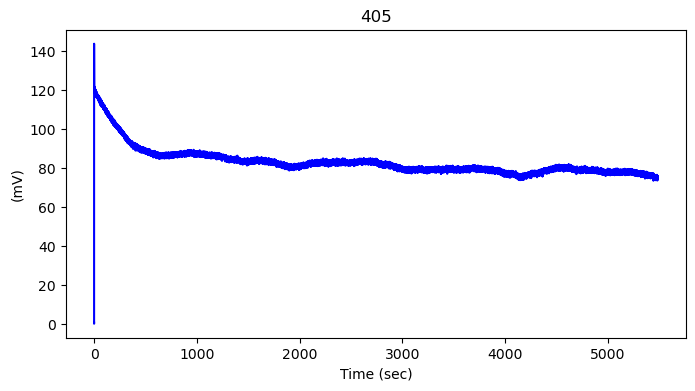

In [361]:
PlotFunctions.plot_sigle_line(x= time_seconds,
                             y= control_whole,
                             Fig_size= (8,4),
                             Fig_title= '405',
                             x_label= 'Time (sec)',
                             y_label= '(mV)',
                             x_lim= (None, None),
                             y_lim= (None, None),
                             colour= 'blue',
                             save= SavePlots)

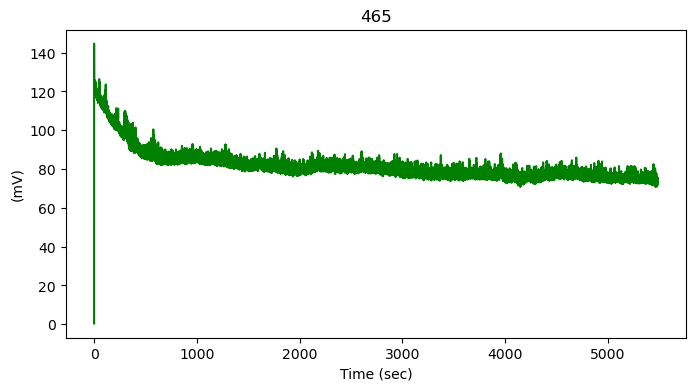

In [362]:
PlotFunctions.plot_sigle_line(x= time_seconds,
                             y= signal_whole,
                             Fig_size= (8,4),
                             Fig_title= '465',
                             x_label= 'Time (sec)',
                             y_label= '(mV)',
                             x_lim= (None, None),
                             y_lim= (None, None),
                             colour= 'green',
                             save= SavePlots)

Or we can browse them at the same time in a merged plot.

In [301]:
# 여기서 아래 plot들의 y-axis scale을 정함. 
ylim_bottom = 85
ylim_top = 120

In [302]:
t = 2
inds = np.where(time_seconds>t)
ind = inds[0][0]
time = time_seconds[ind:] # go from ind to final index
control_raw = control_whole[ind:]
signal_raw = signal_whole[ind:]
time_sec = time_seconds[ind:] 

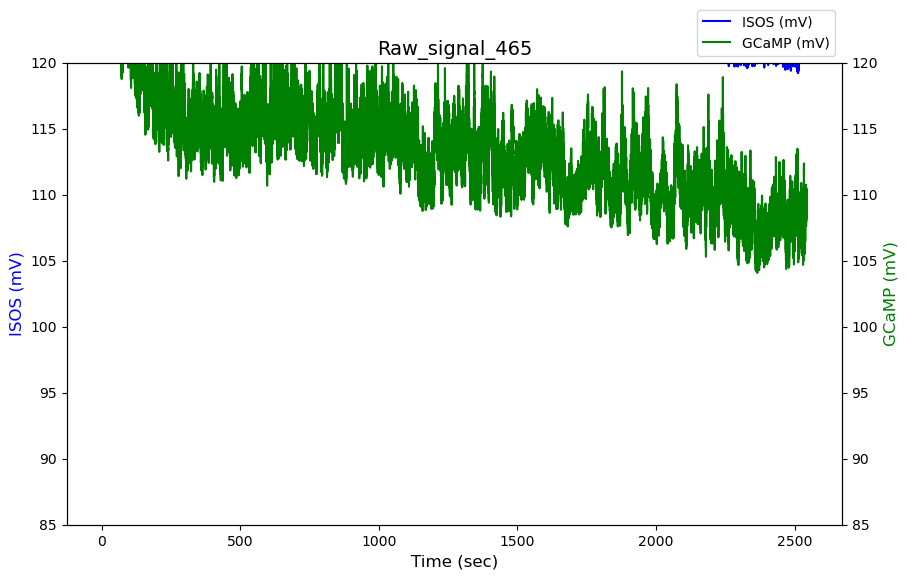

In [303]:
PlotFunctions.plot_dual_line(x1 = time_sec,
                            x2 = time_sec,
                            y1 = control_raw,
                            y2 = signal_raw, 
                            Fig_size = (10,6),
                            Fig_title = 'Raw_signal_465',
                            x_label = 'Time (sec)',
                            y1_label = 'ISOS (mV)',
                            y2_label = 'GCaMP (mV)',
                            x_lim = (None, None),
                            y1_lim = (ylim_bottom, ylim_top),
                            y2_lim = (ylim_bottom, ylim_top),
                            colour1 = 'blue',
                            colour2 = 'green',
                            save = SavePlots)

In [304]:
# data = {'onset':FPdata.epocs.Cam1.onset, 'offset': FPdata.epocs.Cam1.offset}
# df_Cam_ticks = pd.DataFrame(data=data)
# df_Cam_ticks

### 4. Denoising
#### 4-1. Smoothing (Filtering)
In general, the kinetics of physiological signals are slower than that of noise in the recorded signal. In other words, meaningful signals are usually present in the low-frequency components of the recorded signal, whereas noise is present at all frequencies. So, by using low-pass filter, we are able to improve the signal-to-noise ratio of our result. At this step, there are several options available. We can use Zero Phase filtering, Fast Fourier transform, or, simply, Savitzky-Golay filter.  

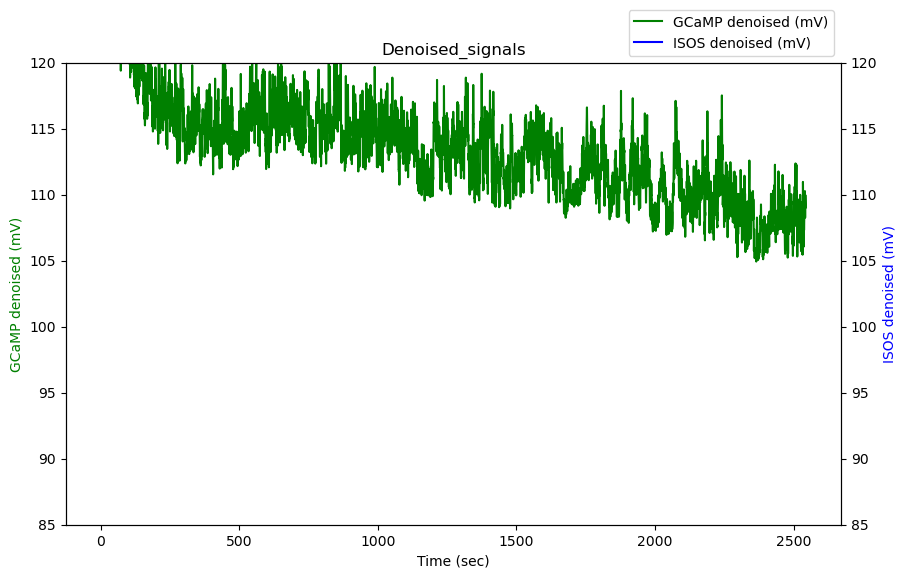

In [305]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(3, 1, btype='low', fs=sampling_rate)
signal_denoised = filtfilt(b,a, signal_raw)
control_denoised = filtfilt(b,a, control_raw)
# signal_denoised = signal_raw # smoothing 전의 raw trace를 가지고 아래 분석을 진행하고 싶다면 이 명령어를 사용해야 함. 
# control_denoised = control_raw # smoothing 전의 raw trace를 가지고 아래 분석을 진행하고 싶다면 이 명령어를 사용해야 함. 


Fig_title = 'Denoised_signals' 
y1_label = 'GCaMP denoised (mV)'
y2_label = 'ISOS denoised (mV)'
x_label = 'Time (sec)'

# plot signals
fig,ax1=plt.subplots(figsize=(10,6))
plot1=ax1.plot(time_sec, signal_denoised, 'g', label=y1_label)
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_denoised, 'b', label=y2_label)

ax1.set_ylim(ylim_bottom, ylim_top)
ax2.set_ylim(ylim_bottom, ylim_top)
ax1.set_xlabel(x_label)
ax1.set_ylabel(y1_label, color='g')
ax2.set_ylabel(y2_label, color='b')
ax1.set_title(Fig_title)

lines = plot1+plot2 #+camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

if SavePlots == True:
    plt.savefig('Plot_{plotname}.png'.format(plotname = Fig_title))

Let's zoom in on the x-axis to see how the lowpass filtering has smoothed the signals.

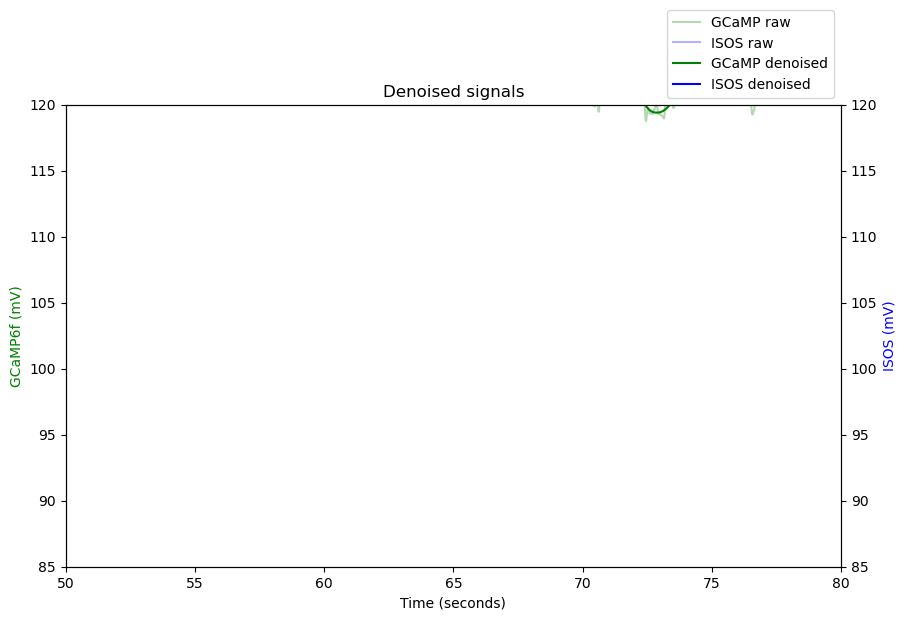

In [306]:
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_raw, color='g', alpha=0.3, label='GCaMP raw')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_raw, color='b', alpha=0.3, label='ISOS raw') 
plot3=ax1.plot(time_sec, signal_denoised, color='g', label='GCaMP denoised') 
plot4=ax2.plot(time_sec, control_denoised, color='b', label='ISOS denoised') 
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick',color='w', marker="|", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f (mV)', color='g')
ax2.set_ylabel('ISOS (mV)', color='b')
ax1.set_title('Denoised signals')

lines = plot1+plot2 + plot3 + plot4 #+ camera_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1))
ax1.set_xlim(50, 80) # 60 sec window
ax1.set_ylim(ylim_bottom, ylim_top)
ax2.set_ylim(ylim_bottom, ylim_top);

#### 4-2. Photobleaching correction (or Detrending)
Now let's compare some different ways of removing the influence of photobleaching

##### Method 1: Double Exponential Fit
One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

In [307]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to GCaMP6f signal.
if CurveFitting == True: 
    max_sig = np.max(signal_denoised) 
    inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
    bounds = ([0      , 0      , 0      , 600  , 0],
              [max_sig, max_sig, max_sig, 36000, 1]) 
    signal_parms, parm_cov = curve_fit(double_exponential, time_sec, signal_denoised,
                                    p0=inital_params, bounds=bounds, maxfev=1000)

signal_expfit = double_exponential(time_sec, *signal_parms)

# Fit curve to Isosbestic signal.
if CurveFitting == True: 
    max_sig = np.max(control_denoised)
    inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
    bounds = ([0      , 0      , 0      , 600  , 0],
              [max_sig, max_sig, max_sig, 36000, 1])
    control_parms, parm_cov = curve_fit(double_exponential, time_sec, control_denoised, 
                                    p0=inital_params, bounds=bounds, maxfev=1000)

control_expfit = double_exponential(time_sec, *control_parms)


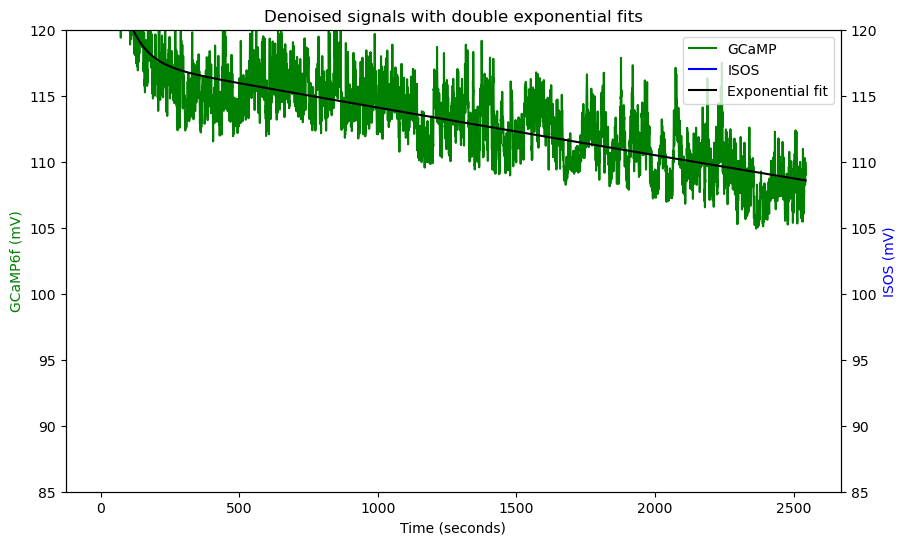

In [308]:
#Fitting 계산시 시간이 많이 걸리므로 fitting과 plotting code를 분리
#plot fits over denoised data
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_denoised, 'g', label='GCaMP')
plot3=ax1.plot(time_sec, signal_expfit, color='k', linewidth=1.5, label='Exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_denoised, color='b', label='ISOS') 
plot4=ax2.plot(time_sec, control_expfit,color='k', linewidth=1.5) 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f (mV)', color='g')
ax2.set_ylabel('ISOS (mV)', color='b')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(ylim_bottom, ylim_top)
ax2.set_ylim(ylim_bottom, ylim_top);

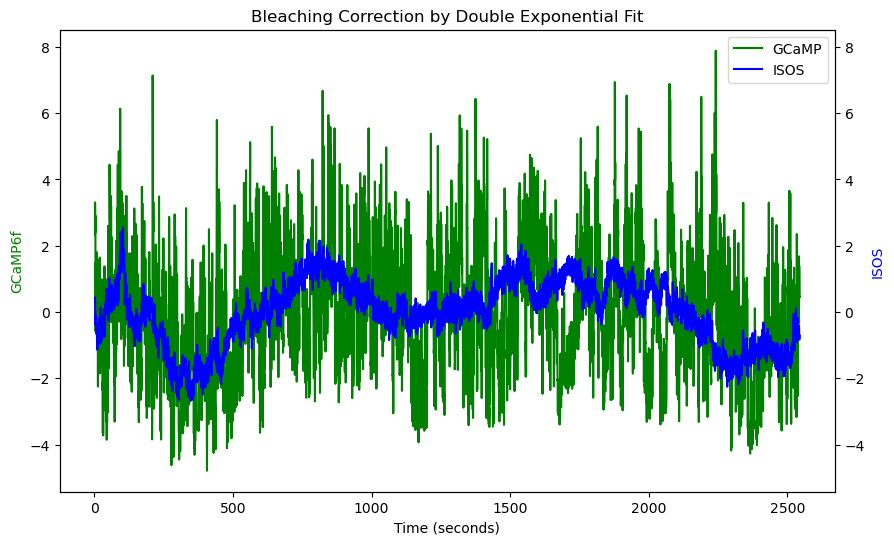

In [309]:
signal_detrended = signal_denoised - signal_expfit
control_detrended = control_denoised - control_expfit

fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_detrended, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_detrended, color='b', label='ISOS') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-5, 10)
ax2.set_ylim(ax1.get_ylim());

##### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes. All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

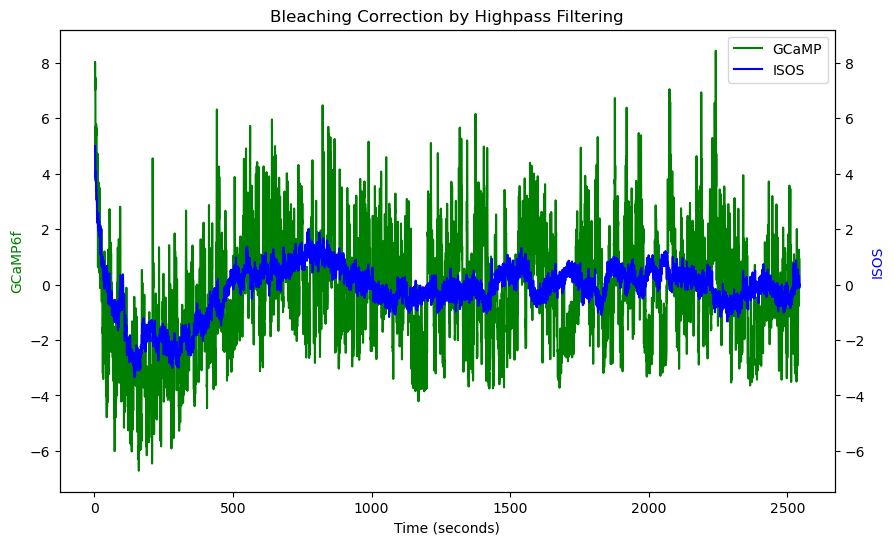

In [310]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
signal_highpass = filtfilt(b,a, signal_denoised, padtype='even')
control_highpass = filtfilt(b,a, control_denoised, padtype='even')

fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_highpass, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_highpass, color='b', label='ISOS') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
# ax1.set_ylim(-5, 10)
ax2.set_ylim(ax1.get_ylim());

#### 4-3. Motion correction
We now do motion correction by finding the best linear fit of the 405 signal to the GCaMP6f signal and subtracting this estimated motion component from the GaMP6f signal. We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

Slope    : 0.392
R-squared: 0.040


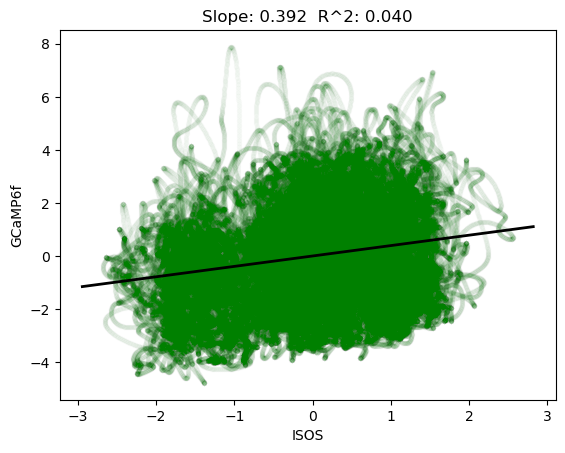

In [311]:
slope, intercept, r_value, p_value, std_err = linregress(x=control_detrended, y=signal_detrended)

plt.scatter(control_detrended[::5], signal_detrended[::5],alpha=0.01, marker='.', color='g')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x, color='k', linewidth=2)
plt.xlabel('ISOS')
plt.ylabel('GCaMP6f')
plt.title('Slope: {:.3f}'.format(slope) +'  ' + 'R^2: {:.3f}'.format(r_value**2))
# plt.text(x=0.4, y=-0.6, s='Slope: {:.3f}'.format(slope))
# plt.text(x=0.4, y=-0.7, s= 'R-squared: {:.3f}'.format(r_value**2) )
# plt.annotate('Slope: {:.3f}'.format(slope) +'  ' + 'R^2: {:.3f}'.format(r_value**2) , xy=(1, 1), xycoords='axes fraction', xytext=(1, 1), textcoords='axes fraction', ha='right', va='bottom')


if SavePlots == True:
    plt.savefig('Plot_405_465_correlation.png')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

We now calculate the estimated motion component of the GCaMP signal and subtract to get the motion corrected signal.

(0.0, 200.0)

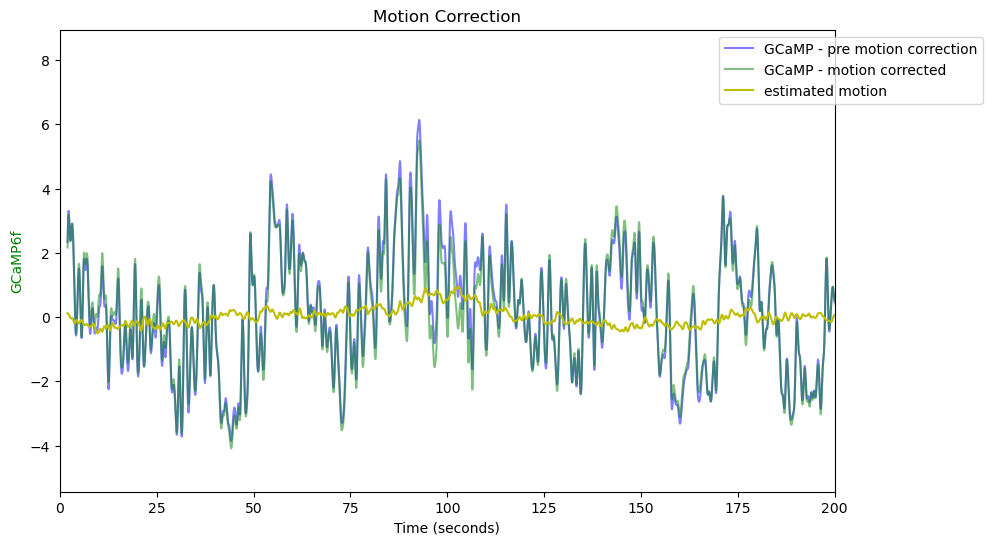

In [312]:
signal_est_motion = intercept + slope * control_detrended
signal_corrected = signal_detrended - signal_est_motion

fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_detrended, 'b' , label='GCaMP - pre motion correction', alpha=0.5)
plot3=ax1.plot(time_sec, signal_corrected, 'g', label='GCaMP - motion corrected', alpha=0.5)
plot4=ax1.plot(time_sec, signal_est_motion - 0.05, 'y', label='estimated motion')
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 2), label='Camera tick',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4 #+ camera_ticks
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

ax1.set_xlim(0, 200)  # 60 sec window
# ax1.set_ylim(-0.075, 0.1);

### 5. Normalization

Typically in a photometry experiment we want to combine data across sessions and/or subjects. This is complicated by the fact that different sessions may have different levels of fluorphore expression, excitation light and autofluorescence. It is therefore desirable to normalise the data to reduce this variability. The two most widely used ways of doing this are computing dF/F or z-scores.

#### Method 1: dF/F
To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above. The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

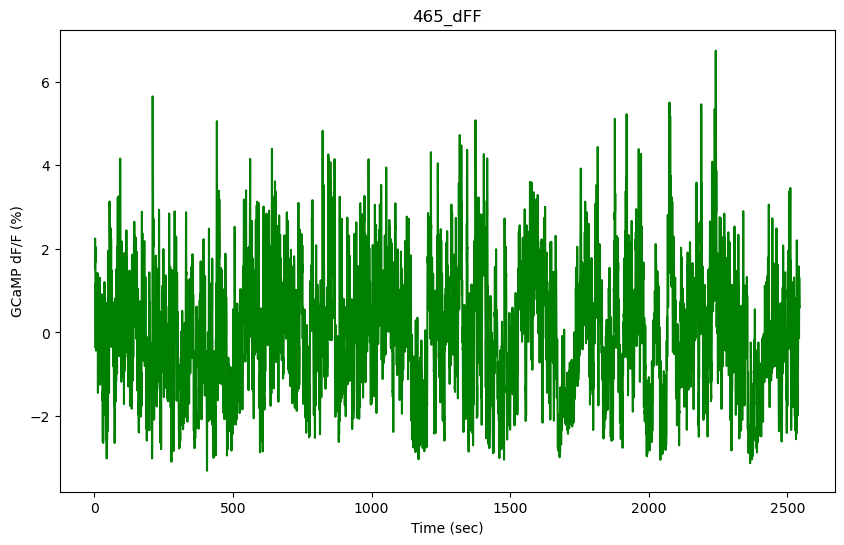

In [313]:
signal_dF_F = 100*signal_corrected/control_expfit

PlotFunctions.plot_sigle_line(x= time_sec,
                             y= signal_dF_F,
                             Fig_size= (10,6),
                             Fig_title= '465_dFF',
                             x_label= 'Time (sec)',
                             y_label= 'GCaMP dF/F (%)',
                             x_lim= (None, None),
                             y_lim= (None, None),
                             colour= 'green',
                             save= SavePlots)

#### Method 2: Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

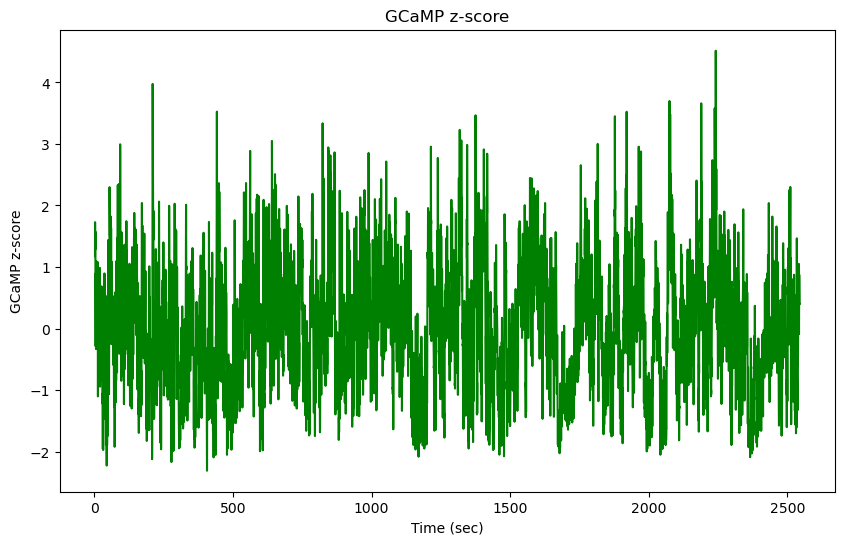

In [314]:
signal_zscored = (signal_corrected-np.mean(signal_corrected))/np.std(signal_corrected)

PlotFunctions.plot_sigle_line(x= time_sec,
                             y= signal_zscored,
                             Fig_size= (10,6),
                             Fig_title= 'GCaMP z-score',
                             x_label= 'Time (sec)',
                             y_label= 'GCaMP z-score',
                             x_lim= (None, None),
                             y_lim= (None, None),
                             colour= 'green',
                             save= SavePlots)

### 6. Exporting results as a pickle file

In [315]:
#가공한 데이터 저장하기
GCaMP_signal = pd.DataFrame({
    'original_time': time_sec,
    'time': time_sec - t,  
    'value': signal_dF_F
})

# SaveData = True
if SaveData == True:
    GCaMP_signal.to_pickle('Final_table_raw_trace.pkl')

GCaMP_signal

,original_time,time,value
0,2.000486,0.000486,1.528954
1,2.001469,0.001469,1.533119
2,2.002452,0.002452,1.537280
3,2.003435,0.003435,1.541439
4,2.004419,0.004419,1.545594
...,...,...,...
2585481,2543.631678,2541.631678,0.597586
2585482,2543.632661,2541.632661,0.597588
2585483,2543.633644,2541.633644,0.597590
2585484,2543.634627,2541.634627,0.597592


In [316]:
df_asr = pd.read_csv("ASR X10.CSV", header = None)
df_asr.columns = ['asr', 'time']
asr_protocol = df_asr['asr'].unique()
asr = np.array(df_asr['asr'])
print(df_asr)
print(df_asr.shape)


        asr      time
0    ASR 85  0.007344
1   ASR 105  0.018220
2   ASR 120  0.019380
3    ASR 75  0.032848
4   ASR 105  0.035882
..      ...       ...
94  ASR 120  0.927510
95   ASR 95  0.957558
96   ASR 80  0.970461
97  ASR 120  0.977066
98   ASR 85  0.987978

[99 rows x 2 columns]
(99, 2)


In [317]:

asr_list = []
asr_dic = {}

for a in df_asr['asr'].unique():
    globals()['asr_{}'.format(a[4:])] = list(np.where(asr == a)[0])
    asr_list.append('asr_{}'.format(a[4:]))
    print(globals()['asr_{}'.format(a[4:])])
    asr_dic['asr_{}'.format(a[4:])] = list(np.where(asr == a)[0])
print(asr_list)
print(asr_dic)
    
    

[0, 12, 35, 46, 57, 70, 72, 82, 98]
[1, 4, 13, 18, 36, 41, 48, 53, 67, 85]
[2, 8, 20, 23, 40, 64, 75, 81, 94, 97]
[3, 6, 24, 33, 39, 42, 56, 60, 69, 92]
[5, 7, 9, 15, 22, 43, 51, 59, 65, 96]
[10, 17, 26, 37, 49, 55, 62, 63, 79, 91]
[11, 14, 21, 25, 29, 31, 45, 47, 74, 84]
[16, 19, 27, 34, 50, 54, 66, 76, 80, 88]
[28, 30, 32, 44, 61, 68, 73, 78, 86, 95]
[38, 52, 58, 71, 77, 83, 87, 89, 90, 93]
['asr_85', 'asr_105', 'asr_120', 'asr_75', 'asr_80', 'asr_100', 'asr_110', 'asr_115', 'asr_95', 'asr_90']
{'asr_85': [0, 12, 35, 46, 57, 70, 72, 82, 98], 'asr_105': [1, 4, 13, 18, 36, 41, 48, 53, 67, 85], 'asr_120': [2, 8, 20, 23, 40, 64, 75, 81, 94, 97], 'asr_75': [3, 6, 24, 33, 39, 42, 56, 60, 69, 92], 'asr_80': [5, 7, 9, 15, 22, 43, 51, 59, 65, 96], 'asr_100': [10, 17, 26, 37, 49, 55, 62, 63, 79, 91], 'asr_110': [11, 14, 21, 25, 29, 31, 45, 47, 74, 84], 'asr_115': [16, 19, 27, 34, 50, 54, 66, 76, 80, 88], 'asr_95': [28, 30, 32, 44, 61, 68, 73, 78, 86, 95], 'asr_90': [38, 52, 58, 71, 77, 83, 87,

asr_85
[0, 12, 35, 46, 57, 70, 72, 82, 98]


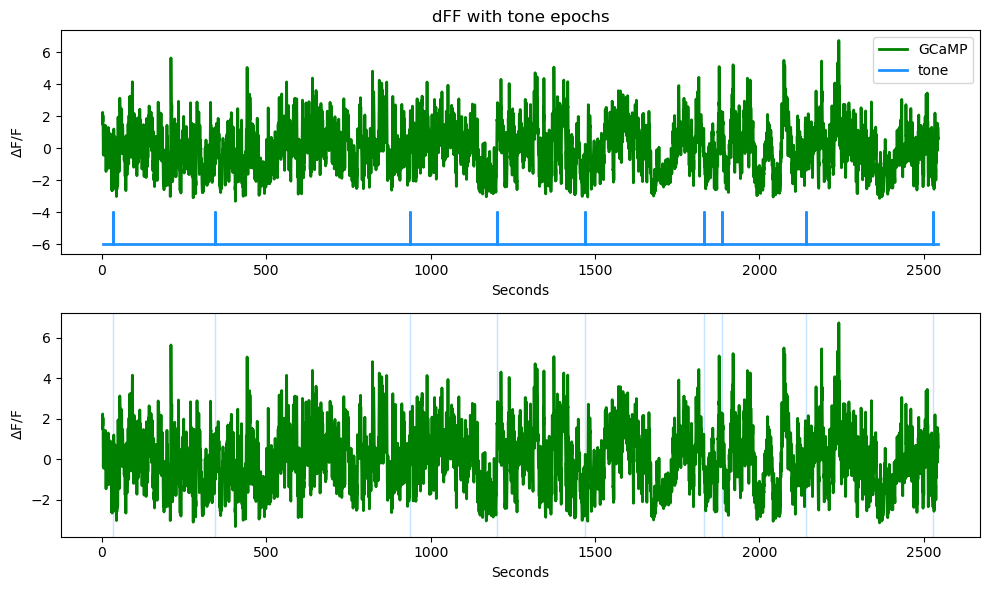

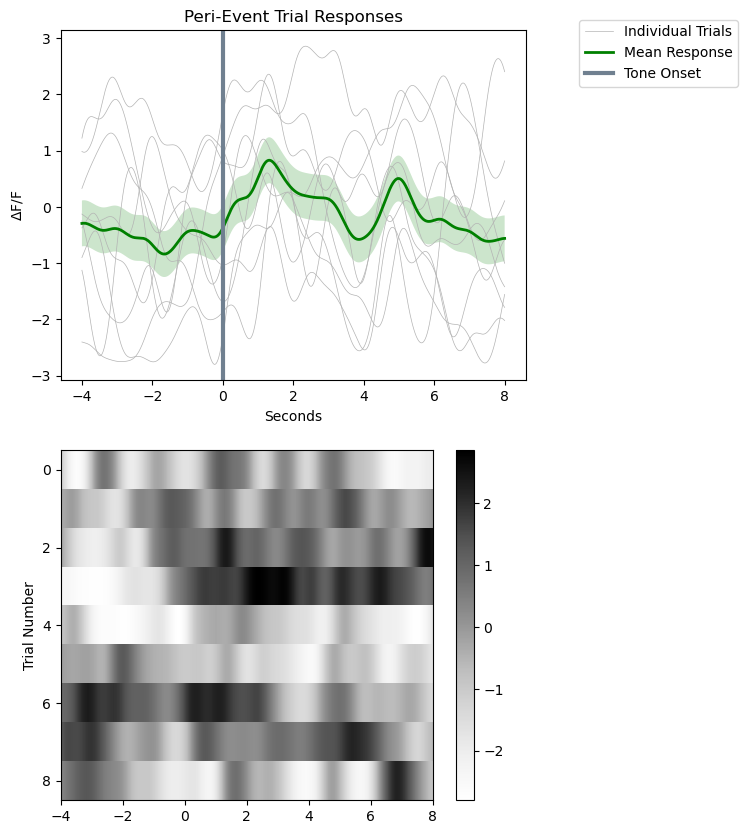

In [319]:
for key in asr_list[:1]:
    print(key)
    print(asr_dic[key])
    tone_on = [FPdata.epocs['PC1_'].onset[i] for i in asr_dic[key]]
    tone_off = [FPdata.epocs['PC1_'].offset[i] for i in asr_dic[key]]
    # Add the first and last time stamps to make tails on the TTL stream
    tone_x = np.append(np.append(time[0], np.reshape(np.kron([tone_on, tone_off],
                    np.array([[1], [1]])).T, [1,-1])[0]), time[-1])
    sz = len(tone_on)
    d = FPdata.epocs['PC1_'].data[asr_dic[key]]
    d2 = np.full(d.shape, fill_value=1)
    # Add zeros to beginning and end of 0,1 value array to match len of tone_x
    tone_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(sz),
        d2, d2, np.zeros(sz)]).T, [1, -1])[0]),0)

    y_scale = 2 #adjust according to data needs
    y_shift = -6 #scale and shift are just for asthetics

    # First subplot in a series: dFF with lick epocs
    fig1 = plt.figure(figsize=(10,6))
    ax2 = fig1.add_subplot(211)

    p1, = ax2.plot(time_sec, signal_dF_F, linewidth=2, color='green', label='GCaMP')
    p2, = ax2.plot(tone_x, y_scale*tone_y+y_shift, linewidth=2, color='dodgerblue', label='tone')
    ax2.set_ylabel(r'$\Delta$F/F')
    ax2.set_xlabel('Seconds')
    ax2.set_title('dFF with tone epochs')
    ax2.legend(handles=[p1,p2], loc='upper right')
    fig1.tight_layout()

    ax4 = fig1.add_subplot(212)
    p1, = ax4.plot(time_sec, signal_dF_F, linewidth=2, color='green', label='GCaMP')
    for on, off in zip(FPdata.epocs['PC1_'].onset[asr_dic[key]], FPdata.epocs['PC1_'].offset[asr_dic[key]]):
        ax4.axvspan(on, off, alpha=0.25, color='dodgerblue')
    ax4.set_ylabel(r'$\Delta$F/F')
    ax4.set_xlabel('Seconds')
    # ax4.set_title('')
    fig1.tight_layout()
    plt.savefig('Plot_{}_tone_epochs.png'.format(key))
    fig1
    
    
    PRE_TIME = 4 # five seconds before event onset
    POST_TIME = 8 # ten seconds after

    # time span for peri-event filtering, PRE and POST, in samples
    TRANGE = [-PRE_TIME*np.floor(sampling_rate), POST_TIME*np.floor(sampling_rate)]

    dFF_snips = []
    array_ind = []
    pre_stim = []
    post_stim = []

    for on in [FPdata.epocs['PC1_'].onset[i] for i in asr_dic[key]]:
        # If the bout cannot include pre-time seconds before event, make zero
        if on < PRE_TIME:
            dFF_snips.append(np.zeros(TRANGE[1]-TRANGE[0]))
        else: 
            # find first time index after bout onset
            array_ind.append(np.where(time > on)[0][0])
            # find index corresponding to pre and post stim durations
            pre_stim.append(array_ind[-1] + TRANGE[0])
            post_stim.append(array_ind[-1] + TRANGE[1])
            dFF_snips.append(signal_dF_F[int(pre_stim[-1]):int(post_stim[-1])])
            
    # Make all snippets the same size based on min snippet length
    min1 = np.min([np.size(x) for x in dFF_snips])
    dFF_snips = [x[1:min1] for x in dFF_snips]

    mean_dFF_snips = np.mean(dFF_snips, axis=0)
    std_dFF_snips = np.std(mean_dFF_snips, axis=0)

    peri_time = np.linspace(1, len(mean_dFF_snips), len(mean_dFF_snips))/sampling_rate - PRE_TIME

    fig2 = plt.figure(figsize=(6,10))
    ax5 = fig2.add_subplot(211)

    for snip in dFF_snips:
        p1, = ax5.plot(peri_time, snip, linewidth=.5, color=[.7, .7, .7], label='Individual Trials')
    p2, = ax5.plot(peri_time, mean_dFF_snips, linewidth=2, color='green', label='Mean Response')

    # Plotting standard error bands
    p3 = ax5.fill_between(peri_time, mean_dFF_snips+std_dFF_snips, 
                        mean_dFF_snips-std_dFF_snips, facecolor='green', alpha=0.2)
    p4 = ax5.axvline(x=0, linewidth=3, color='slategray', label='Tone Onset')

    ax5.axis('tight')
    ax5.set_xlabel('Seconds')
    ax5.set_ylabel(r'$\Delta$F/F')
    ax5.set_title('Peri-Event Trial Responses')
    ax5.legend(handles=[p1, p2, p4], bbox_to_anchor=(1.1, 1.05));
    ax6 = fig2.add_subplot(212)
    cs = ax6.imshow(dFF_snips, cmap=plt.cm.Greys, aspect='auto',
                    interpolation='none', extent=[-PRE_TIME,POST_TIME,len(dFF_snips),0],)
    ax6.set_ylabel('Trial Number')
    ax6.set_yticks(np.arange(.5, len(dFF_snips), 2))
    ax6.set_yticklabels(np.arange(0, len(dFF_snips), 2))
    fig2.colorbar(cs)
    plt.savefig('Plot_{}_peri_event.png'.format(key))

    fig2

In [337]:
import VideoFunctions

In [328]:
FPdata.epocs.PC1_.onset[asr_dic['asr_120']]

array([  84.10546176,  240.91721728,  541.44630784,  614.94362112,
       1063.66533632, 1673.64788224, 1956.26631168, 2125.33379072,
       2419.7668864 , 2503.21371136])

In [345]:
FPS = 10 
df_CamTick = pd.DataFrame({'start_frame': np.floor(FPdata.epocs.PC1_.onset[asr_dic['asr_120']]*FPS)-2*FPS,
                           'end_frame': np.ceil((FPdata.epocs.PC1_.offset[asr_dic['asr_120']])*FPS)+4*FPS})
print(df_CamTick)

   start_frame  end_frame
0        821.0      882.0
1       2389.0     2450.0
2       5394.0     5455.0
3       6129.0     6190.0
4      10616.0    10677.0
5      16716.0    16777.0
6      19542.0    19603.0
7      21233.0    21294.0
8      24177.0    24238.0
9      25012.0    25073.0


In [346]:
VideoFunctions.extract_video_slices(video_path='JJ-YG2-250219-154647_G10_002-250224-171709_Cam1.avi', slices_df=df_CamTick, output_folder='Video_slices_asr_120')

Video slices extraction completed.
